<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/test_lstm/mv_chronos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Preparing metadata (setup.py) ... done
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=8251e39b95bd125aaa77b3c92d7c03aacbbd8292937bcf178c812dde8e7e6957
  Stored in directory: /root/.cache/pip/wheels/36/3b/15/5854a9f4341707e02ee2132ffc13b9b1e719cdad3c3537dc26
Successfully built chronos
  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-j9_zdusl
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-j9_zdusl
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 28e7b3281f68d1493a6290b3aa32902128ad2157
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 25.2 MB/s eta 0:00:00
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=28

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Variance: [  4.5395927   7.8084564   8.279922    6.9867454  10.776463   25.127079
  31.449244   46.423977   39.33399    47.254654   63.14987    55.606384
  62.41349    69.377754   85.36278   104.81877   121.67946   125.16374
 130.01315   144.96097   157.49748   159.47324   172.93927   184.47458
 206.63358   215.07507   229.10686   273.26776   293.88666   325.713    ]


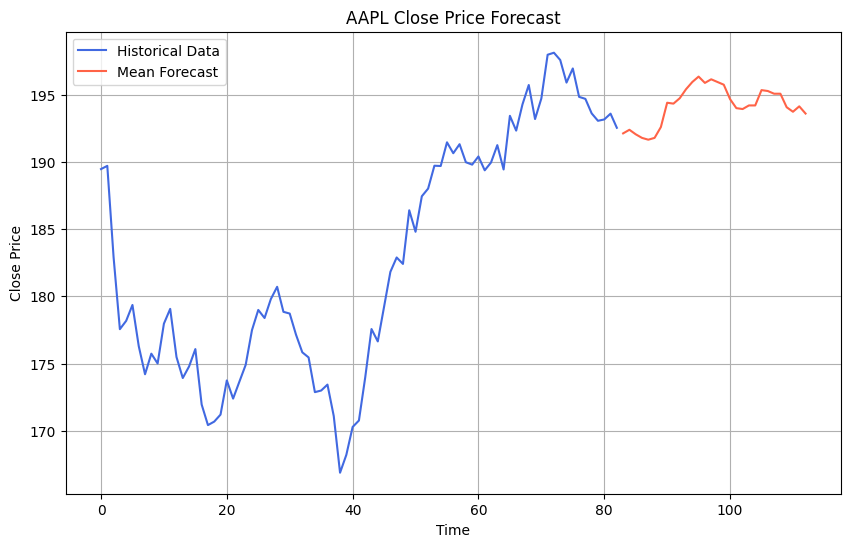

In [2]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda", # cpu for CPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)

#Colonna 'Close' come serie temporale
df = data.reset_index()
close_prices = df["Close"].values.reshape(-1)

#Forecasting
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

#Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
#low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(forecast[0].numpy(), axis=0)
variance_forecast = np.var(forecast[0].numpy(), axis=0)

print(f'Variance: {variance_forecast}')

plt.figure(figsize=(10, 6))
plt.plot(close_prices, color="royalblue", label="Historical Data")
plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
#plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [4]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # per dividere i dati in training e validation

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda", # cuda for CPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2020-01-01", end="2023-12-31", progress=False)

# Usa tutte le colonne come covariate
df = data.reset_index()
covariates = df[["Open", "High", "Low", "Volume"]].values  # Usa tutte le covariate
close_prices = df["Close"].values  # Variabile risposta


def generate_lstm_dataset_with_chronos(covariates, close_prices, pipeline, window_size=30):
    X = []
    Y = []
    for t in range(len(covariates) - window_size):
        # Finestra di covariate
        window = covariates[t:t+window_size]

        # Previsione con CHRONOS per ciascuna covariata
        enriched_window = []
        for i in range(window.shape[1]):  # Itera sulle variabili
            context = torch.tensor(window[:, i], dtype=torch.float32).unsqueeze(0)  # Serie univariata
            forecast = pipeline.predict(context=context, prediction_length=1)  # Predice il giorno successivo
            forecast_mean = np.mean(forecast[0].numpy())  # Media della distribuzione
            forecast_std = np.std(forecast[0].numpy())  # Deviazione standard

            # Replica statistiche di CHRONOS per allinearle alla finestra temporale
            forecast_features = np.tile([forecast_mean, forecast_std], (window_size, 1))  # (window_size, 2)

            # Combina la covariata originale con le statistiche replicate
            enriched_covariate = np.column_stack((window[:, i], forecast_features))  # (window_size, 3)
            enriched_window.append(enriched_covariate)

        # Combina tutte le covariate arricchite in una singola matrice
        enriched_window = np.hstack(enriched_window)  # (window_size, num_features * 3)

        X.append(enriched_window)
        Y.append(close_prices[t+window_size])  # Target: prezzo di chiusura del giorno successivo

    return np.array(X), np.array(Y)


# Generazione del dataset
X, Y = generate_lstm_dataset_with_chronos(covariates, close_prices, pipeline)

# Normalizzazione
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)  # Normalizza a livello globale
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y.reshape(-1, 1))

# Converti in tensori PyTorch
X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, window_size, num_features)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)  # Shape: (num_samples, 1)

# Dividi i dati in training e validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

# Converti in tensori PyTorch
X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32).unsqueeze(1)  # Aggiungi dimensione target
Y_val_split = torch.tensor(Y_val_split, dtype=torch.float32).unsqueeze(1)  # Aggiungi dimensione target

<ipython-input-4-ed2ef40c44d0>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
<ipython-input-4-ed2ef40c44d0>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
<ipython-input-4-ed2ef40c44d0>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32).unsqueeze(1)  # Aggiungi dimensione target
<ipython-input-4-ed2ef40c44d0>:86: UserWarning: To copy construct f

In [13]:
import torch.nn as nn

class LSTMWithChronos(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMWithChronos, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Output LSTM
        out = self.fc(lstm_out[:, -1, :])  # Considera solo l'ultimo step temporale
        return out

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
X_train_split = X_train_split.to(DEVICE)
X_val_split = X_val_split.to(DEVICE)
Y_train_split = Y_train_split.to(DEVICE)
Y_val_split = Y_val_split.to(DEVICE)

print(X.shape)
print(X_train_split.shape)
print(X_val_split.shape)
# Configurazione
input_size = X.shape[2]  # Numero di feature
hidden_size = 128  # Numero di unità nascoste
output_size = 1  # Prezzo di chiusura predetto
model = LSTMWithChronos(input_size, hidden_size, output_size).to(DEVICE)

# Ottimizzatore e funzione di perdita
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.MSELoss()  # Mean Squared Error

# Early stopping
best_loss = float("inf")
patience = 20000  # Numero massimo di epoche senza miglioramenti
patience_counter = 0

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass sul training set
    predictions = model(X_train_split)
    loss = criterion(predictions, Y_train_split)

    # Backpropagation e aggiornamento
    loss.backward()
    optimizer.step()

    # Valutazione sul validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_split)
        val_loss = criterion(val_predictions, Y_val_split)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Early Stopping
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Salva il miglior modello
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

torch.Size([976, 30, 12])
torch.Size([780, 30, 12])
torch.Size([196, 30, 12])
Epoch 1/500, Loss: 1.0282, Val Loss: 1.1481
Epoch 2/500, Loss: 1.1325, Val Loss: 0.9305
Epoch 3/500, Loss: 1.0214, Val Loss: 0.9224
Epoch 4/500, Loss: 1.0253, Val Loss: 0.9262


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([780, 1, 1, 1])) that is different to the input size (torch.Size([780, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([196, 1, 1, 1])) that is different to the input size (torch.Size([196, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/500, Loss: 1.0220, Val Loss: 0.9327
Epoch 6/500, Loss: 1.0186, Val Loss: 0.9422
Epoch 7/500, Loss: 1.0181, Val Loss: 0.9436
Epoch 8/500, Loss: 1.0168, Val Loss: 0.9420
Epoch 9/500, Loss: 1.0163, Val Loss: 0.9397
Epoch 10/500, Loss: 1.0163, Val Loss: 0.9399
Epoch 11/500, Loss: 1.0166, Val Loss: 0.9444
Epoch 12/500, Loss: 1.0161, Val Loss: 0.9485
Epoch 13/500, Loss: 1.0162, Val Loss: 0.9483
Epoch 14/500, Loss: 1.0161, Val Loss: 0.9447
Epoch 15/500, Loss: 1.0159, Val Loss: 0.9407
Epoch 16/500, Loss: 1.0158, Val Loss: 0.9386
Epoch 17/500, Loss: 1.0160, Val Loss: 0.9380
Epoch 18/500, Loss: 1.0160, Val Loss: 0.9386
Epoch 19/500, Loss: 1.0159, Val Loss: 0.9408
Epoch 20/500, Loss: 1.0158, Val Loss: 0.9434
Epoch 21/500, Loss: 1.0158, Val Loss: 0.9453
Epoch 22/500, Loss: 1.0158, Val Loss: 0.9455
Epoch 23/500, Loss: 1.0158, Val Loss: 0.9443
Epoch 24/500, Loss: 1.0157, Val Loss: 0.9427
Epoch 25/500, Loss: 1.0157, Val Loss: 0.9415
Epoch 26/500, Loss: 1.0157, Val Loss: 0.9412
Epoch 27/500, L

<ipython-input-20-2220cb0dc479>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


torch.Size([31, 30, 12])
torch.Size([31, 1])


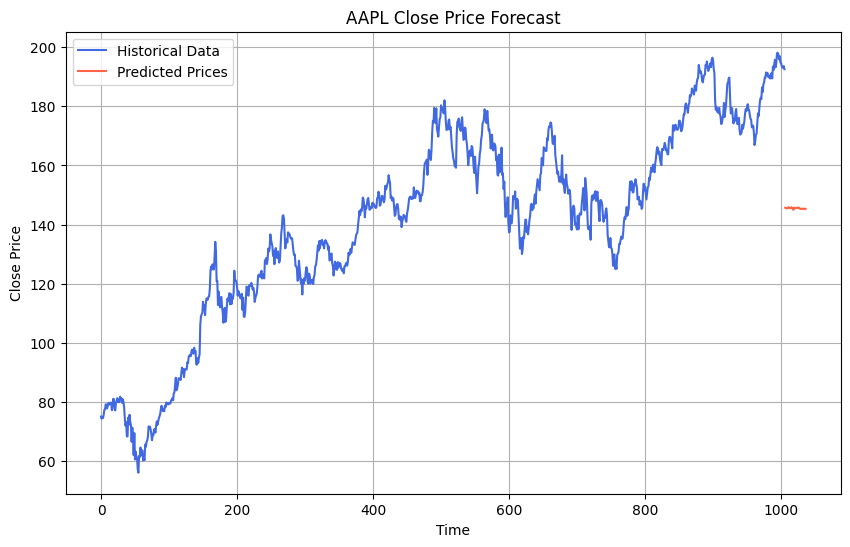

In [20]:
# Nuovi dati
new_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
new_covariates = new_data[["Open", "High", "Low", "Volume"]].values
new_close_prices = new_data["Close"].values

# Genera dati di test con la finestra mobile
X_test, Y_test = generate_lstm_dataset_with_chronos(new_covariates, new_close_prices, pipeline)

# Reshape X_test into 2D for scaling
X_test_2D = X_test.reshape(-1, X_test.shape[2])  # Reshape to (num_samples * window_size, num_features)

# Apply the scaler
X_test_scaled = scaler_x.transform(X_test_2D)  # Scale the data

# Reshape back to 3D
X_test = X_test_scaled.reshape(X_test.shape)  # Reshape back to (num_samples, window_size, num_features)


# Converti in tensore
X_test = torch.tensor(X_test, dtype=torch.float32)

X_test = X_test.to(DEVICE) # This line moves X_test to the GPU

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print(X_test.shape)
with torch.no_grad():
    test_predictions = model(X_test)
print(test_predictions.shape)

# Move predictions to CPU before converting to NumPy
test_predictions = test_predictions.cpu() # Move the tensor to the CPU

test_predictions_original = scaler_y.inverse_transform(test_predictions.numpy())


# Indici temporali per i dati storici e di test
historical_index = np.arange(len(close_prices))  # Dati storici
forecast_index = np.arange(len(close_prices), len(close_prices) + len(test_predictions))  # Previsioni

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(historical_index, close_prices, color="royalblue", label="Historical Data")  # Storici
plt.plot(forecast_index, test_predictions_original, color="tomato", label="Predicted Prices")  # Previsioni
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

<ipython-input-26-50a2796a5dd5>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


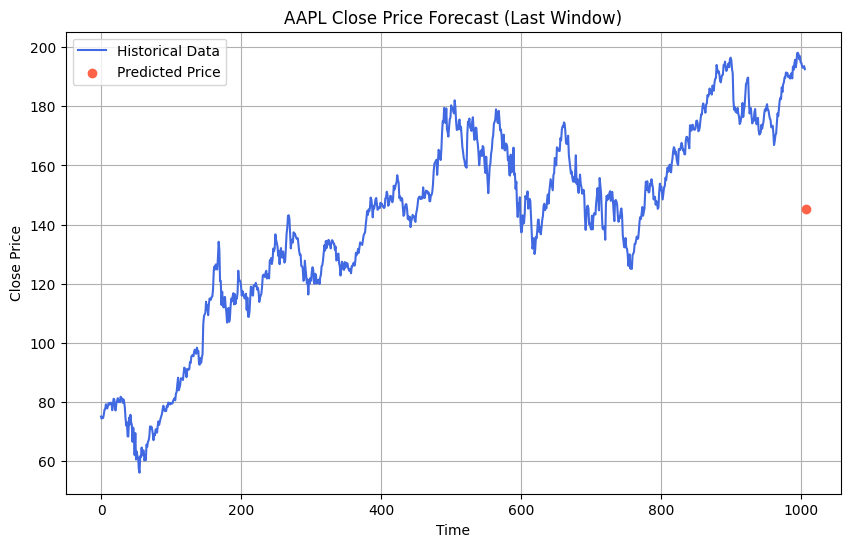

In [26]:
# Estrai solo l'ultima finestra di input
last_window = X_test[-1].unsqueeze(0)  # Prendi l'ultima finestra e aggiungi una dimensione batch

# Previsione sull'ultima finestra
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    last_prediction = model(last_window)

# Trasforma la previsione nella scala originale
last_prediction_original = scaler_y.inverse_transform(last_prediction.cpu().numpy())


# Indici temporali per i dati storici e la previsione dell'ultima finestra
historical_index = np.arange(len(close_prices))  # Dati storici
forecast_index = [len(close_prices)]  # Solo l'ultima previsione

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(historical_index, close_prices, color="royalblue", label="Historical Data")  # Storici
plt.scatter(forecast_index, last_prediction_original, color="tomato", label="Predicted Price", zorder=5)  # Ultima previsione
plt.title(f"{symbol} Close Price Forecast (Last Window)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()
